In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer

In [6]:
train_df = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv")
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
sub_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sub_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [8]:
train_df['tags'].value_counts()

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  40479 non-null  object
 1   tags        40479 non-null  object
dtypes: object(2)
memory usage: 632.6+ KB


In [10]:
train_df.describe()

,image_name,tags
count,40479,40479
unique,40479,449
top,train_0,clear primary
freq,1,13636


In [11]:
train_df.shape

(40479, 2)

In [12]:
# dict for converting labels to numerical classes

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

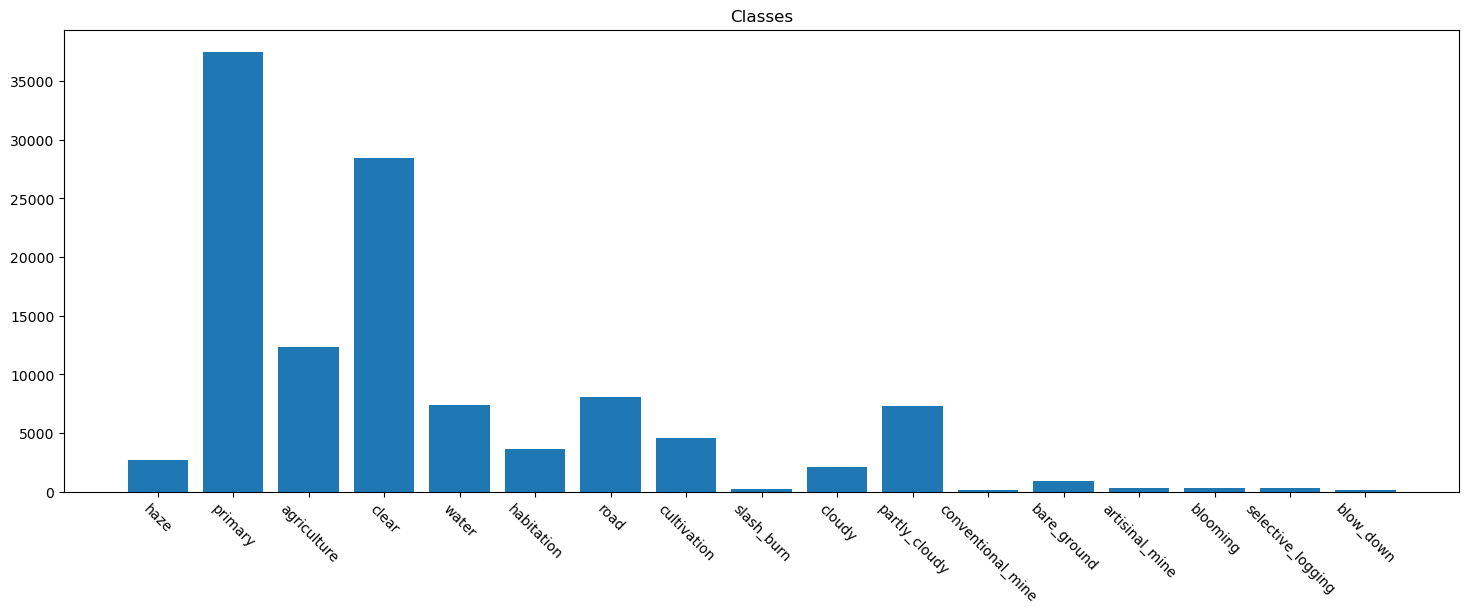

In [13]:
# numbers of tags and their names
counts = {}
splitted_tags = train_df['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

In [14]:
len(splitted_tags)

40479

In [15]:
#load data
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))

def load_data(train_df, labels, resize):
    x_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in train_df.values:
        img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f)) 
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        x_train.append(cv2.resize(img,resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    x_train = np.array(x_train, np.float16) / 255.

    return x_train, y_train

In [16]:
import gc
gc.collect()

4680

In [17]:
x, y = load_data(train_df, labels, resize=(64, 64))

In [18]:
gc.collect()

46

In [19]:
print(x.shape)
print(y.shape)

(40479, 64, 64, 3)
(40479, 17)


In [20]:
print(train_df.shape)
print(sub_df.shape)

(40479, 2)
(61191, 2)


In [21]:
from sklearn.model_selection import train_test_split

import time
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state = int(time.time()))
print(y_train.shape)
print(x_train.shape)
print(x_val.shape)
print(y_val.shape)

(32383, 17)
(32383, 64, 64, 3)
(8096, 64, 64, 3)
(8096, 17)


In [22]:
import torch
import fastai
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastai.vision import *

In [23]:
tfms = aug_transforms(flip_vert = True, max_lighting = 0.1, max_zoom = 1.05, max_warp = 0.)

In [24]:
#import os
path = Path('/kaggle/input/planets-dataset/planet/planet')
#path = Path('/kaggle/input/')
path.ls()

(#4) [Path('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv'),Path('/kaggle/input/planets-dataset/planet/planet/test-jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train_classes.csv'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg')]

In [25]:
train_df.isna().sum()

image_name    0
tags          0
dtype: int64

In [26]:
biner = MultiLabelBinarizer()
tags = train_df['tags'].str.split()
y = biner.fit_transform(tags)

labels = biner.classes_
print('Number of labels: ', len(labels))
print('\n')
print(labels)

Number of labels:  17


['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


### Learning Curve

In [27]:
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

### fbeta Score

In [28]:
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [29]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam

### VGG

In [30]:
optimizer = Adam(0.003, decay=0.0005)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    model = Sequential([
    base_model,
 
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_18 (Flatten)        (None, 2048)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               262272    
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 17)                2193      
                                                                 
Total params: 14,979,153
Trainable params: 264,465
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
model_fit = model.fit( x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(x_val, y_val))


Epoch 1/10
506/506 [==============================] - 18s 24ms/step - loss: 0.1737 - fbeta_score_K: 0.7028 - val_loss: 0.1459 - val_fbeta_score_K: 0.7397
Epoch 2/10
506/506 [==============================] - 11s 22ms/step - loss: 0.1483 - fbeta_score_K: 0.7408 - val_loss: 0.1447 - val_fbeta_score_K: 0.7631
Epoch 3/10
506/506 [==============================] - 10s 20ms/step - loss: 0.1429 - fbeta_score_K: 0.7506 - val_loss: 0.1348 - val_fbeta_score_K: 0.7668
Epoch 4/10
506/506 [==============================] - 11s 21ms/step - loss: 0.1383 - fbeta_score_K: 0.7582 - val_loss: 0.1319 - val_fbeta_score_K: 0.7682
Epoch 5/10
506/506 [==============================] - 10s 20ms/step - loss: 0.1360 - fbeta_score_K: 0.7624 - val_loss: 0.1339 - val_fbeta_score_K: 0.7579
Epoch 6/10
506/506 [==============================] - 10s 20ms/step - loss: 0.1337 - fbeta_score_K: 0.7660 - val_loss: 0.1282 - val_fbeta_score_K: 0.7763
Epoch 7/10
506/506 [==============================] - 11s 21ms/step - loss: 

In [32]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

127/127 [==============================] - 2s 14ms/step
Test score (f1):  0.8845769618207608
Error: 11.54%


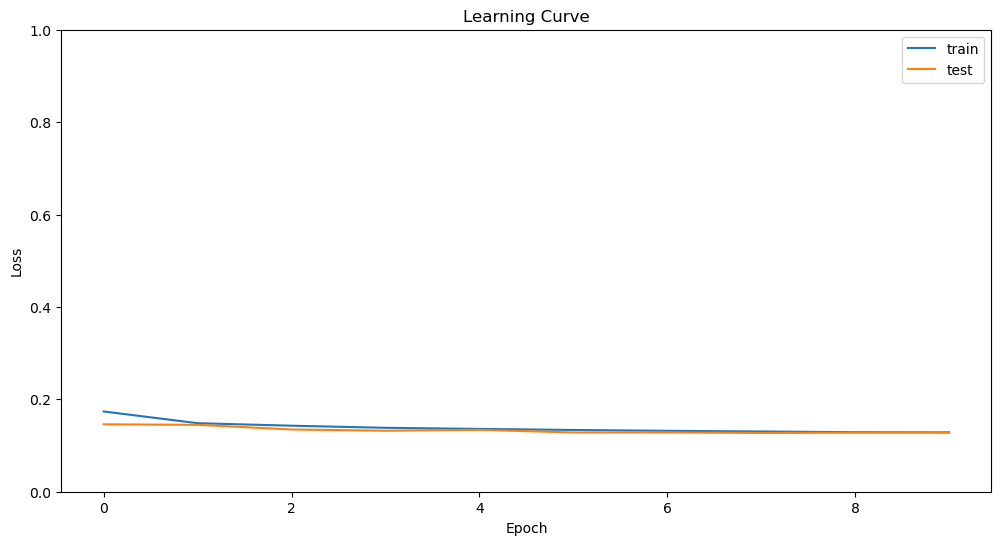

In [33]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [34]:
gc.collect()

6593

In [35]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

127/127 [==============================] - 2s 13ms/step
Test score (f1):  0.8845769618207608
Error: 11.54%


In [36]:
gc.collect()

721

In [37]:
# now to check the Test data

X_test=[]

for img, label in tqdm(sub_df[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img)), (64,64)))

for img, label in tqdm(sub_df[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64,64)))

x_test = np.array(X_test, np.float16)/255

100%|██████████| 20522/20522 [02:17<00:00, 148.83it/s]


In [38]:
x_test.shape


(61191, 64, 64, 3)

In [41]:
Test_Predictions = model.predict(x_test, batch_size = 64)

957/957 [==============================] - 13s 14ms/step


In [42]:
Test_Predictions

array([[5.4747068e-07, 3.1103285e-03, 6.2739459e-04, ..., 6.6064642e-04,
        2.6571422e-04, 2.8857696e-03],
       [3.4649554e-09, 7.4710110e-03, 2.2113722e-02, ..., 2.0310190e-03,
        5.7665410e-04, 1.5718037e-02],
       [4.8271839e-05, 4.2147111e-02, 1.3043516e-04, ..., 1.0663555e-03,
        3.9937068e-04, 3.7274390e-02],
       ...,
       [3.4103137e-05, 6.8876274e-02, 3.4156132e-03, ..., 6.4525427e-03,
        7.3726969e-03, 4.4328850e-02],
       [8.9494485e-01, 4.9652667e-03, 9.0478426e-07, ..., 4.9604021e-04,
        3.3834128e-04, 7.3389925e-02],
       [1.2173111e-03, 5.3710109e-01, 9.7062988e-03, ..., 8.1872630e-01,
        7.6624759e-02, 1.3535278e-01]], dtype=float32)

In [43]:
pred = pd.DataFrame(Test_Predictions, columns= labels)
pred.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,5.474707e-07,0.003110,0.000627,0.999990,0.979920,0.000026,0.001774,0.005518,0.001745,0.000423,0.000004,0.001770,0.005203,0.000003,0.000661,0.000266,0.002886
1,3.464955e-09,0.007471,0.022114,0.999999,0.999583,0.000206,0.013248,0.052357,0.007129,0.005782,0.000024,0.000010,0.001645,0.000008,0.002031,0.000577,0.015718
2,4.827184e-05,0.042147,0.000130,0.999958,0.000213,0.000234,0.015012,0.000059,0.012939,0.000213,0.000020,0.000050,0.999490,0.000009,0.001066,0.000399,0.037274
3,1.108784e-07,0.006339,0.001390,0.999993,0.996536,0.000093,0.004798,0.012178,0.001719,0.002524,0.000009,0.000012,0.004769,0.000004,0.000758,0.000461,0.002718
4,8.822829e-02,0.142047,0.000125,0.918486,0.007621,0.000546,0.026961,0.000316,0.067978,0.000274,0.000853,0.002539,0.871342,0.000611,0.005908,0.007903,0.247798


In [44]:
final_pred = []

for i in tqdm(range(pred.shape[0]), miniters=1000):
    a = pred.loc[[i]]
    a = a.apply(lambda x:x>0.2, axis =1)
    a = a.transpose()
    a = a.loc[a[i]==True]
    ' '.join(list(a.index))
    final_pred.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:55<00:00, 529.25it/s]


In [45]:
gc.collect()

721

In [46]:
sub_df['tags'] = final_pred

In [47]:
sub_df.to_csv('Submission_df.csv', index = False)